In [1]:
import pandas as pd, numpy as np

In [2]:
data = pd.read_csv('cses_cut.csv').iloc[: , 1:]

In [3]:
"""This is a dictionary of the CSES variables. The first index tells if the variable is ordered
and the second is the code(s) for mising values."""
variable_guide = {
    'D2002':(False, [9]),
    'D2003':(True, [97,98,99]),
    'D2004':(False, [9]),
    'D2005':(False, [9]),
    'D2006':(False, [9]),
    'D2007':(False, [9]),
    'D2008':(False, [9]),
    'D2009':(False, [9]),
    'D2010':(False, [99]),
    'D2011':(False, [999]),
    'D2012':(False, [9]),
    'D2013':(False, [9]),
    'D2014':(False, [9]),
    'D2015':(False, [99]),
    'D2016':(False, [999]),
    'D2017':(False, [9]),
    'D2018':(False, [9]),
    'D2019':(False, [9]),
    'D2020':(True, [7,8,9]),
    'D2021':(True, [97,98,99]),
    'D2022':(True, [97,98,99]),
    'D2023':(True, [97,98,99]),
    'D2024':(True, [7,8,9]),
    'D2025':(True, [7,8,9]),
    'D2026':(False, [99]),
    'D2027':(False, [999]),
    'D2028':(False, [99]),
    'D2029':(False, [999]),
    'D2030':(False, [999]),
    'D2031':(True, [7,8,9])
}

In [4]:
start_rows = data.shape[0]

In [5]:
"""Here we replace missing values with NaN."""
for key in variable_guide.keys():
    to_replace={}
    for item in variable_guide[key][1]:
        to_replace[item] = np.nan
    if key == 'D2002':
        to_replace[96]=0
    data[key].replace(to_replace,inplace=True)

In [6]:
"""Here we drop any columns where the percent of null values is greater than 10%.
We then perform listwise-deletion on the rows to elimate any row with a missing value.
Finally, we get dummy variables and replace the voted column with 0 or 1."""
cols_to_drop = list(data.columns[data.isnull().mean() * 100 > 10])
data.drop(cols_to_drop, axis=1, inplace=True)
data.dropna(how='any',inplace=True)
print('Dropped', start_rows-data.shape[0], 'rows!')
to_dummy = [x for x in data.columns if x in variable_guide.keys() and variable_guide[x][0]==False]
print(to_dummy)
data[to_dummy] = data[to_dummy].astype(str)
data=pd.get_dummies(data, prefix=to_dummy)
data['voted'] = data['voted'].astype(int)

Dropped 3191 rows!
['D2002', 'D2004', 'D2005', 'D2010', 'D2026', 'D2028']


In [7]:
y = data['voted']
X = data.drop('voted', axis=1)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from itertools import product
from tqdm.notebook import tqdm

In [13]:
def customGridSearchCV(X, y, k_, rat_, search_space):
    best_cv = None
    best_score_seen = 0
    g = product(k_, rat_)
    p = list(product(rat_, k_))
    # Get the possible combinations of parameters for the sampler and feature selector and iterate over them
    for i in tqdm(range(len(p))):
        params = p[i]
        ros = RandomOverSampler(sampling_strategy=params[0], random_state=1)
        X_, y_ = ros.fit_resample(X, y)
        
        scaler = StandardScaler()
        X_ = scaler.fit_transform(X_)
        
        selector = SelectKBest(mutual_info_classif, k=10)
        X_ = selector.fit_transform(X_, y_)
        
        pipe = Pipeline([('classifier',RandomForestClassifier(n_estimators=100))])
        
        clf = GridSearchCV(pipe, search_space, cv=10, verbose=0, n_jobs=-1, scoring='f1')
        # Perform a grid search and update our best models if needed.
        clf = clf.fit(X_, y_)
        if clf.best_score_ > best_score_seen:
            best_cv = clf
            best_ros = ros
            best_scaler = scaler
            best_selector = selector
            best_score_seen=clf.best_score_
        print(params, clf.best_estimator_, clf.best_score_)
    return best_ros, best_scaler, best_selector, best_cv

In [14]:
# Test three different architectures with varying hyper parameters
k_ = [30, 40, 50, 60, 70]
rat_ = [0.5, 0.6,0.7,0.8,0.9, 1]
search_space = [{'classifier': [LogisticRegression(solver='lbfgs')],
                     'classifier__C': [0.01, 0.1, 1.0],
                     'classifier__penalty': ['l1', 'l2', 'none']},
                    {'classifier': [RandomForestClassifier(n_estimators=100)],
                     'classifier__max_depth': [5, 10, None],
                     'classifier__min_samples_split': [2, 4, 8],
                     'classifier__bootstrap': [True, False]},
                    {'classifier': [KNeighborsClassifier()],
                     'classifier__n_neighbors': [3, 7, 11],
                     'classifier__weights': ['uniform', 'distance'],
                     'classifier__p': [1, 2],
                     'classifier__leaf_size': [15, 30, 100]}]
best = customGridSearchCV(X, y, k_, rat_, search_space)

(0.5, 30) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8809898754003956
(0.5, 40) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8618856514499909
(0.5, 50) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8812121436678716
(0.5, 60) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8650131288248153
(0.5, 70) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8628159260088168
(0.6, 30) Pipeline(steps=[('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=10))]) 0.8226342417966274
(0.6, 40) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8687150233293807
(0.6, 50) Pipeline(steps=[('classifier', RandomForestClassifier(bootstrap=False))]) 0.8866923923068851
(0.6, 60) Pipeline(steps=[('classifier', RandomForestClassifier())]) 0.8206107705425343
(0.6, 70) Pipeline(steps=[('classifier', RandomForestClas

In [15]:
best[3].best_score_

0.8866923923068851

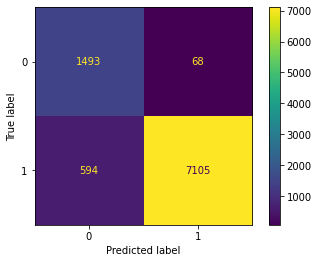

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best[3].best_estimator_, best[2].transform(best[1].transform(X)), y)  
plt.show()

In [25]:
feature_names=X.columns
mask = best[2].get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

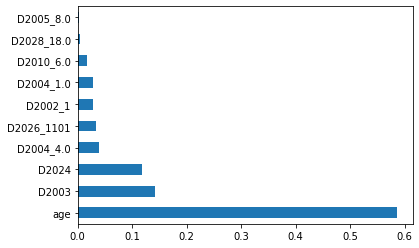

In [36]:
feat_importances = pd.Series(best[3].best_estimator_[0].feature_importances_, index=new_features)
feat_importances.nlargest(10).plot(kind='barh')